In [1]:
with open('./function/requirements_import.py') as f:
    exec(f.read())
    
from sklearn.model_selection import train_test_split

In [2]:
file_path = './data/'
rainfall = pd.read_csv(file_path + 'rainfall_train_v4_eda2.csv')
lis_srt = joblib.load(file_path + 'lis_srt.pkl')

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )

In [16]:
# CatBoost로 추출한 변수중요도 0.5이상인 데이터만 추출
col2 = [x[1] for x in lis_srt if x[0]>=0.5]
col2.remove('pred_YN')

# 종속변수
target = 'class_interval'

# x, y
x = rainfall.drop(columns=[target])
x = rainfall.loc[:, col2]

y = rainfall.loc[:, target]

# GAF : 시계열 -> 이미지
gaf = GramianAngularField(method='summation')
x_gaf = gaf.fit_transform(x)
x_gaf4 = x_gaf.reshape(-1, len(col2), len(col2), 1)


# 각 범주의 최소 데이터 수 찾기
ind_class = [np.where(y == i)[0] for i in range(10)]
min_samples = min(len(indices) for indices in ind_class)

# 각 범주에서 최소 데이터 수만큼 랜덤 샘플 추출
bal_ind = np.hstack([np.random.choice(indices, min_samples, replace=False) for indices in ind_class])

# 추출한 인덱스로 데이터와 레이블 준비
bal_x = x_gaf4[bal_ind]
bal_y = y[bal_ind]

# 7:1.7:1.3 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(bal_x, bal_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

MemoryError: Allocation failed (probably too large).

In [14]:
# import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Rescaling
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split

clear_session()

# 사전 학습된 VGG16 모델을 사용하여 특징 추출 (입력 크기를 VGG16에 맞게 조정)
gaf_data_3ch = np.repeat(bal_x, 3, axis=-1)
gaf_data_resized = tf.image.resize(gaf_data_3ch, (64, 64))
model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

# Layer 추가
x = model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1000, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

new_model = Model(inputs = model.input, outputs = x)

for layer in new_model.layers:
    layer.trainable = False
    
new_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,44

 Total params: 27,867,458 (106.31 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,867,458 (106.31 MB)

In [15]:
# 학습 데이터와 테스트 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(gaf_data_resized.numpy(), bal_y, test_size=0.2, random_state=42)

# 모델 학습
history = new_model.fit(x_train, y_train, epochs = 100, callbacks=[es], validation_data=(x_test, y_test)).history

# 예측
pred = new_model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Epoch 1/100
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 716s 409ms/step - accuracy: 0.1148 - csi_metric: 0.0689 - loss: 2.3098 - val_accuracy: 0.1129 - val_csi_metric: 0.0671 - val_loss: 2.3095
Epoch 2/100
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 706s 405ms/step - accuracy: 0.1148 - csi_metric: 0.0689 - loss: 2.3098 - val_accuracy: 0.1129 - val_csi_metric: 0.0671 - val_loss: 2.3095
Epoch 3/100
1326/1740 ━━━━━━━━━━━━━━━━━━━━ 2:12 321ms/step - accuracy: 0.1144 - csi_metric: 0.0690 - loss: 2.3097

KeyboardInterrupt: 

In [ ]:
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth= 5)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, early_stopping_rounds=100, plot=True)

# 학습곡선 출력
plt.show()

# 예측
pred_1 = catboost_model.predict(X_test)

# 결과 출력
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test, pred_1)}')

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2865031	test: 2.2874544	best: 2.2874544 (0)	total: 816ms	remaining: 13m 34s
100:	learn: 2.0858976	test: 2.1124829	best: 2.1124829 (100)	total: 1m 17s	remaining: 11m 26s
200:	learn: 2.0578761	test: 2.0973115	best: 2.0973115 (200)	total: 2m 29s	remaining: 9m 52s
300:	learn: 2.0352426	test: 2.0875932	best: 2.0875932 (300)	total: 3m 40s	remaining: 8m 33s
400:	learn: 2.0176082	test: 2.0812410	best: 2.0812410 (400)	total: 4m 45s	remaining: 7m 6s
500:	learn: 2.0025536	test: 2.0761342	best: 2.0761342 (500)	total: 5m 47s	remaining: 5m 45s
600:	learn: 1.9891528	test: 2.0720785	best: 2.0720785 (600)	total: 6m 48s	remaining: 4m 31s
700:	learn: 1.9768214	test: 2.0688642	best: 2.0688642 (700)	total: 7m 49s	remaining: 3m 20s
800:	learn: 1.9651719	test: 2.0662430	best: 2.0662430 (800)	total: 8m 50s	remaining: 2m 11s
900:	learn: 1.9543603	test: 2.0634879	best: 2.0634879 (900)	total: 9m 51s	remaining: 1m 5s
999:	learn: 1.9432942	test: 2.0610819	best: 2.0610819 (999)	total: 10m 53s	remaining:

: 

In [ ]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train.shape[1:]), # input_shape=(32, 32, 3)
                    # Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    # MaxPooling2D(pool_size = 2 ),
                                        Conv2D(64, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),

    Conv2D(128, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
                    Flatten(),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train, y_train, epochs = 100, callbacks=[lr_sch, es], validation_data=(x_val, y_val)).history

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 27, 27, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 27, 27, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        46,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,354 (474.04 KB)

 Trainable params: 120,970 (472.54 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.1854 - csi_metric: 0.1138 - loss: 2.1685 - val_accuracy: 0.1912 - val_csi_metric: 0.1232 - val_loss: 2.1486 - learning_rate: 3.6788e-04
Epoch 2/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.2013 - csi_metric: 0.1322 - loss: 2.1143 - val_accuracy: 0.1999 - val_csi_metric: 0.1390 - val_loss: 2.1250 - learning_rate: 3.3287e-04
Epoch 3/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.2057 - csi_metric: 0.1363 - loss: 2.1059 - val_accuracy: 0.1961 - val_csi_metric: 0.1316 - val_loss: 2.1229 - learning_rate: 3.2956e-04
Epoch 4/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.2088 - csi_metric: 0.1388 - loss: 2.1025 - val_accuracy: 0.1984 - val_csi_metric: 0.1365 - val_loss: 2.1218 - learning_rate: 3.2923e-04
Epoch 5/100
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.2109 - csi_metric: 0.1410 - loss: 2.0990 - val_accuracy: 0.1936 - val_csi_metric: 0.1355 - val_loss: 

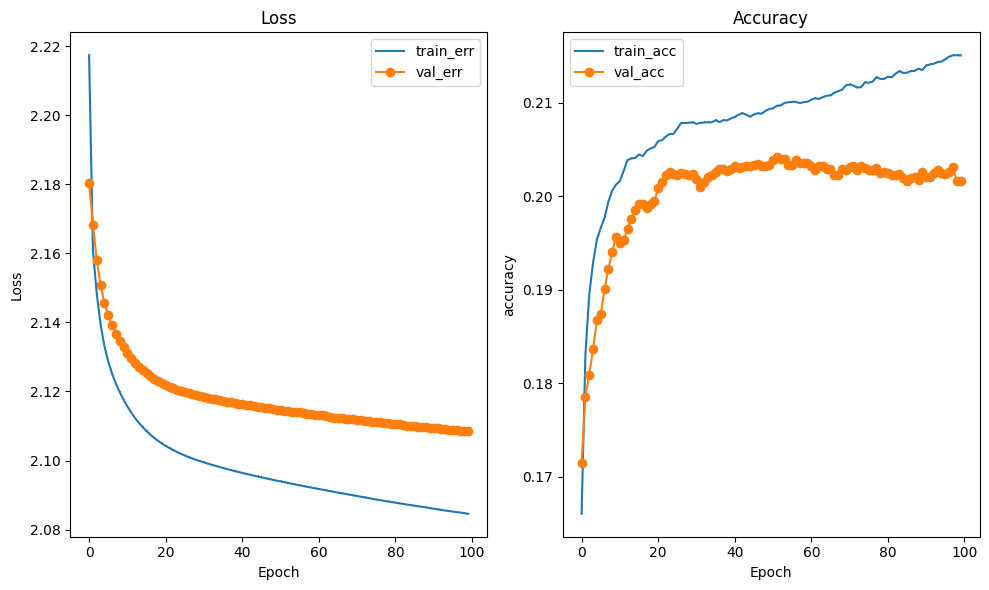

In [ ]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# model.save(file_path + 'tune_best2.keras')

------

In [ ]:
file_path = './data/'
df = pd.read_csv(file_path + 'rainfall_test_v4_eda2.csv')
col = joblib.load(file_path + 'lis_col.pkl')
col.remove('pred_YN')

temp = df[col]

gaf = GramianAngularField(method='summation')
test_gaf = gaf.fit_transform(temp)
test_gaf4 = test_gaf.reshape(-1, len(col), len(col), 1)

In [ ]:
pred = model.predict(test_gaf4)
pred_1 = pred.argmax(axis=1)

df2 = pd.read_csv(file_path + 'rainfall_test.csv')
df2['rainfall_test.class_interval'] = pred_1
df2

,Unnamed: 0,rainfall_test.fc_year,rainfall_test.fc_month,rainfall_test.fc_day,rainfall_test.fc_hour,rainfall_test.stn4contest,rainfall_test.dh,rainfall_test.ef_year,rainfall_test.ef_month,rainfall_test.ef_day,...,rainfall_test.v01,rainfall_test.v02,rainfall_test.v03,rainfall_test.v04,rainfall_test.v05,rainfall_test.v06,rainfall_test.v07,rainfall_test.v08,rainfall_test.v09,rainfall_test.class_interval
0,1,D,5,1,9,STN031,3,D,5,1,...,68,46,13,1,0,0,0,0,0,NaN
1,2,D,5,1,9,STN031,6,D,5,1,...,83,66,26,5,0,0,0,0,0,NaN
2,3,D,5,1,9,STN031,9,D,5,1,...,17,6,0,0,0,0,0,0,0,NaN
3,4,D,5,1,9,STN031,12,D,5,1,...,0,0,0,0,0,0,0,0,0,NaN
4,5,D,5,1,9,STN031,15,D,5,2,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,121996,D,9,30,21,STN035,228,D,10,10,...,4,4,4,2,2,0,0,0,0,NaN
121996,121997,D,9,30,21,STN035,231,D,10,10,...,8,6,6,5,0,0,0,0,0,NaN
121997,121998,D,9,30,21,STN035,234,D,10,10,...,8,6,6,5,0,0,0,0,0,NaN
121998,121999,D,9,30,21,STN035,237,D,10,10,...,10,8,8,8,6,2,0,0,0,NaN


In [ ]:
df2.to_csv('./240258.csv', index=False)